##Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import random
import os
import time
from tqdm import tqdm
import json
import requests
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

##Loading Data to local

In [12]:

training_url = "https://raw.githubusercontent.com/saivikas10/Assignment-2/refs/heads/main/training.json"
validation_url = "https://raw.githubusercontent.com/saivikas10/Assignment-2/refs/heads/main/validation.json"
test_url = "https://raw.githubusercontent.com/saivikas10/Assignment-2/refs/heads/main/test.json"

# Downloadingn dataset files from GitHub
def download_data(url, filename):
    response = requests.get(url)
    with open(filename, 'w') as file:
        file.write(response.text)

download_data(training_url, 'training_data.json')
download_data(validation_url, 'validation_data.json')
download_data(test_url, 'test_data.json')
print("Data files downloaded successfully.")


Data files downloaded successfully.


##FFNN Model

In [13]:
unk = '<UNK>'
# Define the FFNN model class
class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU()
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):

        # Getting the hidden layer output
        hidden_output = self.activation(self.W1(input_vector))

        # Getting the output layer input
        output_input = self.W2(hidden_output)

        # Checking if the output input is 2D (batch size, output dim)
        if output_input.dim() == 1:
            output_input = output_input.unsqueeze(0)

        # Applying softmax to get the predicted probabilities
        predicted_vector = self.softmax(output_input)
        return predicted_vector

##Helper Functions

In [14]:
# Returns:
# vocab = A set of strings corresponding to the vocabulary
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab

# Returns:
# vocab = A set of strings corresponding to the vocabulary including <UNK>
# word2index = A dictionary mapping word/token to its index (a number in 0, ..., V - 1)
# index2word = A dictionary inverting the mapping of word2index
def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {}
    index2word = {}
    for index, word in enumerate(vocab_list):
        word2index[word] = index
        index2word[index] = word
    vocab.add(unk)
    return vocab, word2index, index2word


# Returns:
# vectorized_data = A list of pairs (vector representation of input, y)
def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data

# Loading of training and tessting data
def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = []
    val = []
    for elt in training:
        tra.append((elt["text"].split(), int(elt["stars"] - 1)))
    for elt in validation:
        val.append((elt["text"].split(), int(elt["stars"] - 1)))

    return tra, val

In [15]:
# Seting default configurations
hidden_dim = 10
epochs = 5

# Runing main training loop with default configurations
print("========== Loading data ==========")
train_data, valid_data = load_data('training_data.json', 'validation_data.json')
vocab = make_vocab(train_data)
vocab, word2index, index2word = make_indices(vocab)

print("========== Vectorizing data ==========")
train_data = convert_to_vector_representation(train_data, word2index)
valid_data = convert_to_vector_representation(valid_data, word2index)

print("==========Running Model for Default Configuration==========")
print("Hidden_dim =", hidden_dim)
print("Epochs =", epochs)
print("Learning Rate =", 0.01)
print("Batch Size =", 16)

model = FFNN(input_dim=len(vocab), h=hidden_dim)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
print("========== Training for {} epochs ==========".format(epochs))
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Training started for epoch {}".format(epoch + 1))
    random.shuffle(train_data)
    minibatch_size = 16
    N = len(train_data)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    print("Training completed for epoch {}".format(epoch + 1))
    print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Training time for this epoch: {}".format(time.time() - start_time))

    # Validation
    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Validation started for epoch {}".format(epoch + 1))
    minibatch_size = 16
    N = len(valid_data)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
    print("Validation completed for epoch {}".format(epoch + 1))
    print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Validation time for this epoch: {}".format(time.time() - start_time))

========== Loading data ==========
========== Vectorizing data ==========
==========Running Model for Default Configuration==========
Hidden_dim = 10
Epochs = 5
Learning Rate = 0.01
Batch Size = 16
========== Training for 5 epochs ==========
Training started for epoch 1


100%|██████████| 1000/1000 [00:40<00:00, 24.70it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.38325
Training time for this epoch: 40.519893169403076
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 102.89it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.47875
Validation time for this epoch: 0.5102505683898926
Training started for epoch 2


100%|██████████| 1000/1000 [00:44<00:00, 22.45it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4963125
Training time for this epoch: 44.56657314300537
Validation started for epoch 2


100%|██████████| 50/50 [00:01<00:00, 45.11it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.49875
Validation time for this epoch: 1.1324644088745117
Training started for epoch 3


100%|██████████| 1000/1000 [00:46<00:00, 21.45it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5325625
Training time for this epoch: 46.66253900527954
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 108.20it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.53125
Validation time for this epoch: 0.4691472053527832
Training started for epoch 4


100%|██████████| 1000/1000 [00:44<00:00, 22.57it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5579375
Training time for this epoch: 44.32746505737305
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 102.93it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.51875
Validation time for this epoch: 0.494854211807251
Training started for epoch 5


100%|██████████| 1000/1000 [00:45<00:00, 21.84it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5838125
Training time for this epoch: 45.81553554534912
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 106.87it/s]

Validation completed for epoch 5
Validation accuracy for epoch 5: 0.615
Validation time for this epoch: 0.47478389739990234


### **Code to Run Different Configurations and Plot the Best Model**

In [16]:
#Dataset class for handling data format in DataLoader
class ReviewDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_vector, label = self.data[idx]
        return input_vector, label

# Defining the configuration and evaluation function
def train_and_evaluate(config, config_num):
    model = FFNN(input_dim=len(vocab), h=config['hidden_dim'])
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    batch_size = config['batch_size']


    train_loader = DataLoader(ReviewDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(ReviewDataset(valid_data), batch_size=batch_size, shuffle=False)

    #Variables for tracking accuracies and losses of epoch
    train_losses, validation_accuracies, train_accuracies = [], [], []
    print(f"\nCONFIGURATION {config_num}:")
    print(f"Hidden Dim: {config['hidden_dim']}, Epochs: {config['epochs']}, "
          f"Learning Rate: {config['learning_rate']}, Batch Size: {batch_size}")

    for epoch in range(config['epochs']):
        # Training phase with mini-batches
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0
        print(f"Epoch {epoch + 1}/{config['epochs']}:")

        # Progress bar for training phase
        for input_vectors, gold_labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False):
            optimizer.zero_grad()
            predicted_vectors = model(input_vectors)
            loss = model.compute_Loss(predicted_vectors, gold_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy for the batch
            predicted_labels = torch.argmax(predicted_vectors, dim=1)
            correct_train += (predicted_labels == gold_labels).sum().item()
            total_train += gold_labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for input_vectors, gold_labels in val_loader:
                predicted_vectors = model(input_vectors)
                correct_val += (torch.argmax(predicted_vectors, dim=1) == gold_labels).sum().item()
                total_val += gold_labels.size(0)
        validation_accuracy = correct_val / total_val
        validation_accuracies.append(validation_accuracy)

        #Showing results of the current epoch after loading completes
        print(f"Training Loss = {train_loss:.4f}, Training Accuracy = {train_accuracy:.4f}, "
              f"Validation Accuracy = {validation_accuracy:.4f}")

    #Showing final training and validation accuracy of current configuration
    print(f"\nFinal Training Accuracy for Config {config_num}: {train_accuracies[-1]:.4f}")
    print(f"Final Validation Accuracy for Config {config_num}: {validation_accuracies[-1]:.4f}")
    print("==============\n")

    return train_losses, train_accuracies, validation_accuracies, validation_accuracies[-1]

# Configurations set for hyperparameter tuning with Stochastic Gradient Descent
configs = [
    {'epochs': 5, 'hidden_dim': 5, 'learning_rate': 0.01, 'batch_size': 16},
    {'epochs': 10, 'hidden_dim': 5, 'learning_rate': 0.01, 'batch_size': 16},
    {'epochs': 5, 'hidden_dim': 10, 'learning_rate': 0.1, 'batch_size': 32},
    {'epochs': 10, 'hidden_dim': 10, 'learning_rate': 0.01, 'batch_size': 32},
    {'epochs': 15, 'hidden_dim': 15, 'learning_rate': 0.001, 'batch_size': 64}
]

#Variables for tracking best model
best_validation_accuracy = 0
best_train_losses, best_train_accuracies, best_validation_accuracies = None, None, None
best_configuration = None
config_num = 1

#Running model for each configuration and print the results
for config in configs:
    train_losses, train_accuracies, validation_accuracies, final_validation_accuracy = train_and_evaluate(config, config_num)

    # Track the best model according to validation accuracy
    if final_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = final_validation_accuracy
        best_train_losses, best_train_accuracies, best_validation_accuracies = train_losses, train_accuracies, validation_accuracies
        best_configuration = config
    config_num += 1

#Printing the best model configurations
print("\nBest Configuration:")
print(f"Hidden Dim: {best_configuration['hidden_dim']}")
print( f"Epochs: {best_configuration['epochs']}")
print(f"Learning Rate: {best_configuration['learning_rate']}")
print(f"Batch Size: {best_configuration['batch_size']}")
print(f"Best Validation Accuracy: {best_validation_accuracy:.4f}")


CONFIGURATION 1:
Hidden Dim: 5, Epochs: 5, Learning Rate: 0.01, Batch Size: 16
Epoch 1/5:


Training Loss = 1.4470, Training Accuracy = 0.3508, Validation Accuracy = 0.5112
Epoch 2/5:


Training Loss = 1.2188, Training Accuracy = 0.4777, Validation Accuracy = 0.5400
Epoch 3/5:


Training Loss = 1.1234, Training Accuracy = 0.5200, Validation Accuracy = 0.5088
Epoch 4/5:


Training Loss = 1.0698, Training Accuracy = 0.5452, Validation Accuracy = 0.5950
Epoch 5/5:


Training Loss = 1.0163, Training Accuracy = 0.5676, Validation Accuracy = 0.5300

Final Training Accuracy for Config 1: 0.5676
Final Validation Accuracy for Config 1: 0.5300


CONFIGURATION 2:
Hidden Dim: 5, Epochs: 10, Learning Rate: 0.01, Batch Size: 16
Epoch 1/10:


Training Loss = 1.4729, Training Accuracy = 0.3158, Validation Accuracy = 0.3262
Epoch 2/10:


Training Loss = 1.3533, Training Accuracy = 0.3651, Validation Accuracy = 0.2250
Epoch 3/10:


Training Loss = 1.2910, Training Accuracy = 0.3957, Validation Accuracy = 0.4925
Epoch 4/10:


Training Loss = 1.1432, Training Accuracy = 0.4974, Validation Accuracy = 0.4263
Epoch 5/10:


Training Loss = 1.0389, Training Accuracy = 0.5463, Validation Accuracy = 0.3500
Epoch 6/10:


Training Loss = 0.9912, Training Accuracy = 0.5654, Validation Accuracy = 0.4188
Epoch 7/10:


Training Loss = 0.9688, Training Accuracy = 0.5789, Validation Accuracy = 0.5725
Epoch 8/10:


Training Loss = 0.9190, Training Accuracy = 0.5992, Validation Accuracy = 0.4163
Epoch 9/10:


Training Loss = 0.9002, Training Accuracy = 0.6143, Validation Accuracy = 0.5550
Epoch 10/10:


Training Loss = 0.8715, Training Accuracy = 0.6315, Validation Accuracy = 0.5537

Final Training Accuracy for Config 2: 0.6315
Final Validation Accuracy for Config 2: 0.5537


CONFIGURATION 3:
Hidden Dim: 10, Epochs: 5, Learning Rate: 0.1, Batch Size: 32
Epoch 1/5:


Training Loss = 1.5768, Training Accuracy = 0.2399, Validation Accuracy = 0.3962
Epoch 2/5:


Training Loss = 1.4932, Training Accuracy = 0.2999, Validation Accuracy = 0.0625
Epoch 3/5:


Training Loss = 1.5849, Training Accuracy = 0.2446, Validation Accuracy = 0.4000
Epoch 4/5:


Training Loss = 1.4459, Training Accuracy = 0.3446, Validation Accuracy = 0.3975
Epoch 5/5:


Training Loss = 1.5036, Training Accuracy = 0.3124, Validation Accuracy = 0.3800

Final Training Accuracy for Config 3: 0.3124
Final Validation Accuracy for Config 3: 0.3800


CONFIGURATION 4:
Hidden Dim: 10, Epochs: 10, Learning Rate: 0.01, Batch Size: 32
Epoch 1/10:


Training Loss = 1.3858, Training Accuracy = 0.4079, Validation Accuracy = 0.3625
Epoch 2/10:


Training Loss = 1.1903, Training Accuracy = 0.5059, Validation Accuracy = 0.5100
Epoch 3/10:


Training Loss = 1.0602, Training Accuracy = 0.5501, Validation Accuracy = 0.5575
Epoch 4/10:


Training Loss = 0.9976, Training Accuracy = 0.5821, Validation Accuracy = 0.5737
Epoch 5/10:


Training Loss = 0.9499, Training Accuracy = 0.6014, Validation Accuracy = 0.5687
Epoch 6/10:


Training Loss = 0.8912, Training Accuracy = 0.6234, Validation Accuracy = 0.4950
Epoch 7/10:


Training Loss = 0.8275, Training Accuracy = 0.6519, Validation Accuracy = 0.4913
Epoch 8/10:


Training Loss = 0.7965, Training Accuracy = 0.6693, Validation Accuracy = 0.6025
Epoch 9/10:


Training Loss = 0.7738, Training Accuracy = 0.6818, Validation Accuracy = 0.5275
Epoch 10/10:


Training Loss = 0.7122, Training Accuracy = 0.7044, Validation Accuracy = 0.5525

Final Training Accuracy for Config 4: 0.7044
Final Validation Accuracy for Config 4: 0.5525


CONFIGURATION 5:
Hidden Dim: 15, Epochs: 15, Learning Rate: 0.001, Batch Size: 64
Epoch 1/15:


Training Loss = 1.5797, Training Accuracy = 0.2643, Validation Accuracy = 0.3438
Epoch 2/15:


Training Loss = 1.4869, Training Accuracy = 0.3860, Validation Accuracy = 0.3812
Epoch 3/15:


Training Loss = 1.4087, Training Accuracy = 0.4291, Validation Accuracy = 0.3713
Epoch 4/15:


Training Loss = 1.3489, Training Accuracy = 0.4546, Validation Accuracy = 0.4288
Epoch 5/15:


Training Loss = 1.2972, Training Accuracy = 0.4796, Validation Accuracy = 0.4675
Epoch 6/15:


Training Loss = 1.2523, Training Accuracy = 0.5024, Validation Accuracy = 0.4450
Epoch 7/15:


Training Loss = 1.2131, Training Accuracy = 0.5175, Validation Accuracy = 0.5038
Epoch 8/15:


Training Loss = 1.1812, Training Accuracy = 0.5282, Validation Accuracy = 0.5463
Epoch 9/15:


Training Loss = 1.1495, Training Accuracy = 0.5417, Validation Accuracy = 0.5425
Epoch 10/15:


Training Loss = 1.1249, Training Accuracy = 0.5500, Validation Accuracy = 0.4975
Epoch 11/15:


Training Loss = 1.1004, Training Accuracy = 0.5639, Validation Accuracy = 0.5262
Epoch 12/15:


Training Loss = 1.0737, Training Accuracy = 0.5743, Validation Accuracy = 0.5262
Epoch 13/15:


Training Loss = 1.0553, Training Accuracy = 0.5810, Validation Accuracy = 0.5250
Epoch 14/15:


Training Loss = 1.0314, Training Accuracy = 0.5928, Validation Accuracy = 0.5238
Epoch 15/15:


Training Loss = 1.0127, Training Accuracy = 0.6021, Validation Accuracy = 0.5375

Final Training Accuracy for Config 5: 0.6021
Final Validation Accuracy for Config 5: 0.5375


Best Configuration:
Hidden Dim: 5
Epochs: 10
Learning Rate: 0.01
Batch Size: 16
Best Validation Accuracy: 0.5537


##Plotting the accuracy vs Epochs

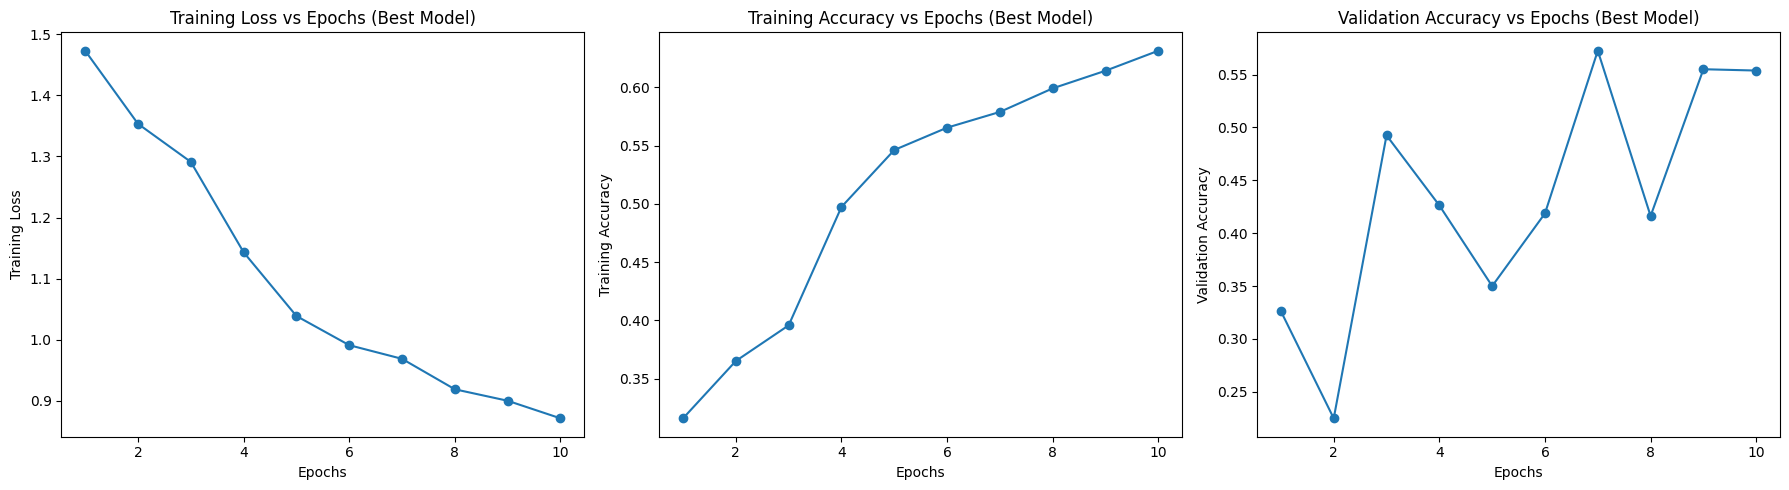

In [17]:
plt.figure(figsize=(18, 5))

# Training Loss plot
plt.subplot(1, 3, 1)
plt.title('Training Loss vs Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.plot(range(1, len(best_train_losses) + 1), best_train_losses, marker='o')

# Training Accuracy plot
plt.subplot(1, 3, 2)
plt.title('Training Accuracy vs Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.plot(range(1, len(best_train_accuracies) + 1), best_train_accuracies, marker='o')

# Validation Accuracy plot
plt.subplot(1, 3, 3)
plt.title('Validation Accuracy vs Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.plot(range(1, len(best_validation_accuracies) + 1), best_validation_accuracies, marker='o')

plt.tight_layout()
plt.show()

### **Testing the Best Model**

In [20]:
#Evaluation function for Test Data
def evaluate_on_test_data(model, test_data):
    model.eval()
    test_correct, test_total = 0, 0
    test_loader = DataLoader(ReviewDataset(test_data), batch_size=best_configuration['batch_size'])

    with torch.no_grad():
        for input_vectors, gold_label in test_loader:
            predicted_vector = model(input_vectors)
            predicted_label = torch.argmax(predicted_vector, dim=1)
            test_correct += (predicted_label == gold_label).sum().item()
            test_total += gold_label.size(0)

    test_accuracy = test_correct / test_total if total > 0 else 0
    print(f"Test Accuracy for Best Model: {test_accuracy:.4f}")

# Ensuring test_data is vectorized using the same word2index as used for training and validation data
test_data = load_data('test_data.json', 'test_data.json')[0]
test_data = convert_to_vector_representation(test_data, word2index)

# Evaluating the Best model
BestModel = FFNN(input_dim=len(vocab), h=best_configuration['hidden_dim'])
evaluate_on_test_data(BestModel, test_data)

Test Accuracy for Best Model: 0.4000
